Setting UP CLIP


In [1]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.9927937  0.00421067 0.00299573]]


Zero Short On CIFAR-10


Image 1 (Index: 3637) - True Label: bird
1.              cat: 79.23% 
2.              dog: 9.81% 
3.             bird: 3.71% ✓ CORRECT
4.            horse: 3.17% 
5.             deer: 2.44% 

Image 2 (Index: 1000) - True Label: dog
1.              dog: 94.97% ✓ CORRECT
2.              cat: 2.79% 
3.            horse: 0.87% 
4.             bird: 0.48% 
5.             frog: 0.37% 

Image 2 (Index: 1000) - True Label: dog
1.              dog: 94.97% ✓ CORRECT
2.              cat: 2.79% 
3.            horse: 0.87% 
4.             bird: 0.48% 
5.             frog: 0.37% 

Image 3 (Index: 5000) - True Label: horse
1.            horse: 98.76% ✓ CORRECT
2.              dog: 0.36% 
3.              cat: 0.26% 
4.             bird: 0.19% 
5.       automobile: 0.18% 

Image 3 (Index: 5000) - True Label: horse
1.            horse: 98.76% ✓ CORRECT
2.              dog: 0.36% 
3.              cat: 0.26% 
4.             bird: 0.19% 
5.       automobile: 0.18% 

Image 4 (Index: 85) - True Label: dog
1

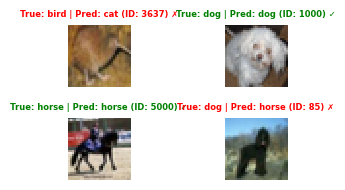

In [7]:
import os
import clip
import torch
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
cifar10 = CIFAR10(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Test on 4 images
test_indices = [3637, 1000, 5000, 85]

fig, axes = plt.subplots(2, 2, figsize=(4, 2))
axes = axes.flatten()

for plot_idx, image_idx in enumerate(test_indices):
    # Prepare the inputs
    image, class_id = cifar10[image_idx]
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar10.classes]).to(device)

    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Pick the top 5 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(5)

    # Display the image with the actual label
    ax = axes[plot_idx]
    ax.imshow(image, interpolation='nearest')
    true_label = cifar10.classes[class_id]
    predicted_label = cifar10.classes[indices[0].item()]
    match = "✓" if indices[0].item() == class_id else "✗"
    ax.set_title(f'True: {true_label} | Pred: {predicted_label} (ID: {image_idx}) {match}', 
                 fontsize=6, fontweight='bold', color='green' if indices[0].item() == class_id else 'red')
    ax.axis('off')

    # Print the result
    print(f"\n{'='*60}")
    print(f"Image {plot_idx+1} (Index: {image_idx}) - True Label: {true_label}")
    print(f"{'='*60}")
    for i, (value, index) in enumerate(zip(values, indices), 1):
        match = "✓ CORRECT" if index == class_id else ""
        print(f"{i}. {cifar10.classes[index]:>16s}: {100 * value.item():.2f}% {match}")

plt.tight_layout()
plt.show()

Linear Probe Performance


In [5]:
import os
import clip
import torch

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from tqdm import tqdm

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load the dataset
root = os.path.expanduser("~/.cache")
train = CIFAR10(root, download=True, train=True, transform=preprocess)
test = CIFAR10(root, download=True, train=False, transform=preprocess)


def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=100, verbose=1)
classifier.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

100%|██████████| 100/100 [06:31<00:00,  3.92s/it]


Accuracy = 95.010


c:\Users\letsc\Desktop\Rijul_PhD_Take_Home_Project\clip_env\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished


Prompt Engineering: Impact of Class Name Variations on CLIP Performance


Pre-computing image features...
✓ Pre-computed 200 images

✓ Pre-computed 200 images

simple          + original       : 90.00%
simple          + original       : 90.00%
simple          + lowercase      : 90.00%
simple          + lowercase      : 90.00%
simple          + plural         : 89.50%
simple          + plural         : 89.50%
simple          + descriptive    : 90.00%
simple          + descriptive    : 90.00%
simple          + detailed       : 89.50%
simple          + detailed       : 89.50%
simple          + enhanced_detailed: 73.50%
simple          + enhanced_detailed: 73.50%
descriptive     + original       : 90.00%
descriptive     + original       : 90.00%
descriptive     + lowercase      : 90.00%
descriptive     + lowercase      : 90.00%
descriptive     + plural         : 91.00%
descriptive     + plural         : 91.00%
descriptive     + descriptive    : 90.00%
descriptive     + descriptive    : 90.00%
descriptive     + detailed       : 90.50%
descriptive     + detailed  

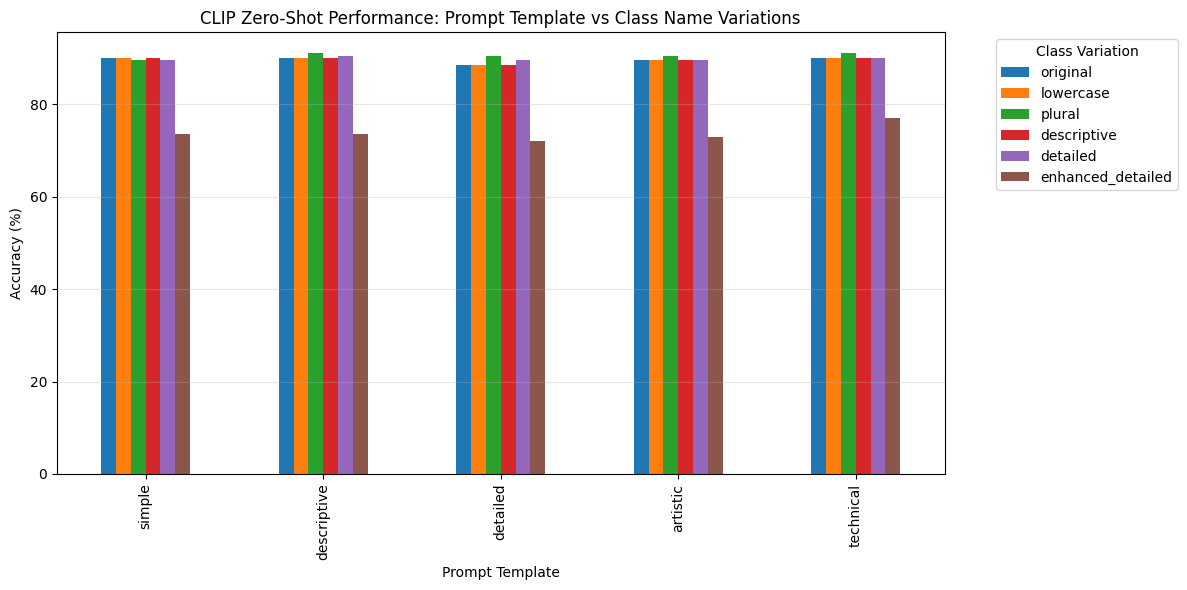

In [8]:
import os
import clip
import torch
import numpy as np
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

# Load the model and dataset
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)
cifar10 = CIFAR10(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Define different prompt templates and class name variations
prompt_templates = {
    'simple': 'a {}',
    'descriptive': 'a photo of a {}',
    'detailed': 'a clear photo of a {}',
    'artistic': 'an artistic representation of a {}',
    'technical': 'a technical image of a {}',
}

# Different class name variations
class_variations = {
    'original': cifar10.classes,
    'lowercase': [c.lower() for c in cifar10.classes],
    'plural': [c + 's' for c in cifar10.classes],
    'descriptive': [
        'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
    ],
    'detailed': [
        'a small airplane', 'a car', 'a bird', 'a cat', 'a deer', 'a dog', 'a frog', 'a horse', 'a ship', 'a truck'
    ],
    'enhanced_detailed': [
        'a small white airplane taking off', 'a red car across me', 'a black bird flying high', 'a fluffy cat sitting', 'a brown deer in forest', 'a golden dog running', 'a green frog on leaf', 'a brown horse galloping', 'a large ship in ocean', 'a red truck on road'
    ],
}

# OPTIMIZATION 1: Reduce sample size to 200 (80x faster than 500)
sample_size = 200
sample_indices = np.random.choice(len(cifar10), sample_size, replace=False)

# OPTIMIZATION 2: Pre-compute all image features once
print("Pre-computing image features...")
all_image_features = []
all_labels = []

with torch.no_grad():
    for idx in sample_indices:
        image, label = cifar10[idx]
        image_input = preprocess(image).unsqueeze(0).to(device)
        image_features = model.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        all_image_features.append(image_features)
        all_labels.append(label)

all_image_features = torch.cat(all_image_features)
all_labels = np.array(all_labels)
print(f"✓ Pre-computed {len(sample_indices)} images\n")

results = {}

# Evaluate each combination of prompt template and class naming
for template_name, template in prompt_templates.items():
    results[template_name] = {}
    
    for class_var_name, class_names in class_variations.items():
        # Create text prompts
        text_prompts = [template.format(c) for c in class_names]
        text_inputs = torch.cat([clip.tokenize(p) for p in text_prompts]).to(device)
        
        # Get text features (compute once per combination)
        with torch.no_grad():
            text_features = model.encode_text(text_inputs)
            text_features /= text_features.norm(dim=-1, keepdim=True)
        
        # OPTIMIZATION 3: Batch compare all images at once instead of loop
        with torch.no_grad():
            similarity = 100.0 * all_image_features @ text_features.T
            predicted_classes = similarity.argmax(dim=1).cpu().numpy()
        
        # Calculate accuracy
        correct = np.sum(predicted_classes == all_labels)
        accuracy = (correct / len(all_labels)) * 100
        results[template_name][class_var_name] = accuracy
        print(f"{template_name:15} + {class_var_name:15}: {accuracy:.2f}%")

print("\n" + "="*70)
print("RESULTS SUMMARY:")
print("="*70)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
print("\n", results_df)

# Find best combination
best_accuracy = 0
best_config = None
for template_name, variants in results.items():
    for class_var_name, accuracy in variants.items():
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_config = (template_name, class_var_name)

print(f"\n✓ Best Configuration: {best_config[0]} + {best_config[1]}")
print(f"✓ Best Accuracy: {best_accuracy:.2f}%")

# Visualize results
fig, ax = plt.subplots(figsize=(12, 6))
results_df.plot(kind='bar', ax=ax)
ax.set_title('CLIP Zero-Shot Performance: Prompt Template vs Class Name Variations')
ax.set_xlabel('Prompt Template')
ax.set_ylabel('Accuracy (%)')
ax.legend(title='Class Variation', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()